In [20]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
print(dataset.head())
values = dataset.values
values

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [21]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [22]:
# ensure all data is float
values = values.astype('float32')
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

In [23]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

In [24]:
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

print(reframed.shape)





(43797, 32)


In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

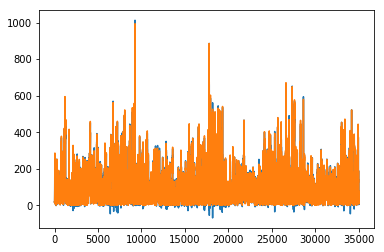

In [3]:
pyplot.plot(inv_yhat)
pyplot.plot(inv_y)
pyplot.show()

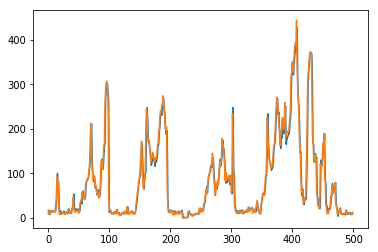

In [15]:
pyplot.plot(inv_yhat[-500:])
pyplot.plot(inv_y[-500:])
pyplot.show()

In [8]:
test_X[:, -7:]

array([[0.33823532, 0.1967213 , 0.83636475, ..., 0.0145091 , 0.        ,
        0.        ],
       [0.32352942, 0.18032786, 0.83636475, ..., 0.006101  , 0.        ,
        0.        ],
       [0.32352942, 0.18032786, 0.83636475, ..., 0.006101  , 0.        ,
        0.        ],
       ...,
       [0.2647059 , 0.26229507, 0.7818184 , ..., 0.40558836, 0.        ,
        0.        ],
       [0.2647059 , 0.26229507, 0.7818184 , ..., 0.41399646, 0.        ,
        0.        ],
       [0.2647059 , 0.24590163, 0.7818184 , ..., 0.4208665 , 0.        ,
        0.        ]], dtype=float32)

In [10]:
reframed.shape

(43797, 32)